# Assess plate effect presence

In [25]:
import pandas as pd
import anndata as ad
import numpy as np
from collections.abc import Iterable
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import SmoothBivariateSpline
from scipy.ndimage import gaussian_filter
import dask
from dask.diagnostics import ProgressBar
import scanpy as sc
from libpysal.weights import lat2W
from esda.moran import Moran

raw_data_path = Path("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/raw.parquet")
mad_int_featselect_data_path = Path("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/mad_int_featselect.parquet")

In [2]:
def find_feat_cols(cols: Iterable[str]):
    """Find column names for features"""
    return [c for c in cols if not c.startswith("Meta")]


def find_meta_cols(cols: Iterable[str]):
    """Find column names for metadata"""
    return [c for c in cols if c.startswith("Meta")]

def to_anndata(parquet_path):
    meta, feats, features = split_parquet(parquet_path)
    meta.index = meta.index.astype(str)
    adata = ad.AnnData(feats, meta)
    adata.var_names = features
    return adata


def split_parquet(dframe_path,
                  features=None) -> tuple[pd.DataFrame, np.ndarray, list[str]]:
    dframe = pd.read_parquet(dframe_path)
    if features is None:
        features = find_feat_cols(dframe)
    vals = np.empty((len(dframe), len(features)), dtype=np.float32)
    for i, c in enumerate(features):
        vals[:, i] = dframe[c]
    meta = dframe[find_meta_cols(dframe)].copy()
    return meta, vals, features

In [3]:
adata = to_anndata(mad_int_featselect_data_path)
adata

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'

## Assess which features have plate effects

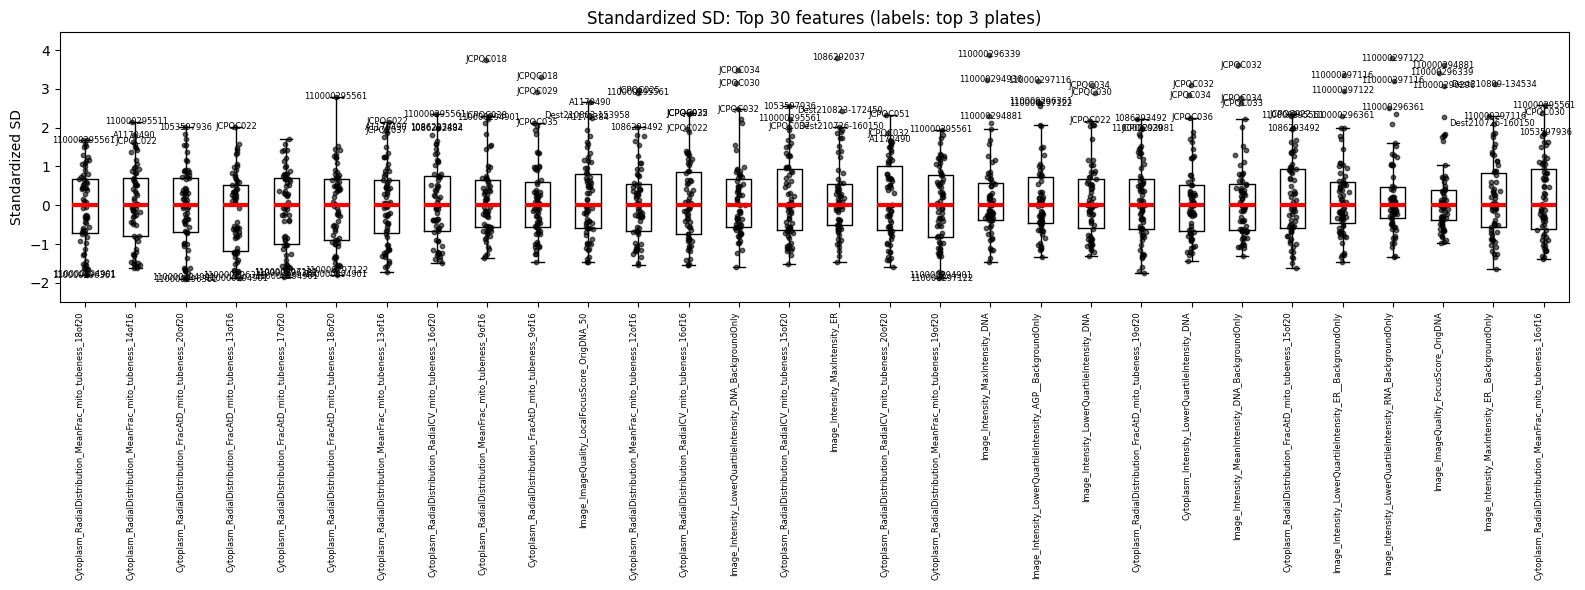

In [52]:

def plot_sorted_sd_boxplots(
    adata,
    plate_col: str = "Metadata_Plate",
    drug_id_col: str = "Metadata_JCP2022",
    drug_id_for_replicates: str = "DMSO",
    top_n: int = 20,
    standardize: bool = True,
    label_top_m: int = 3
) -> None:
    """
    Boxplot of per-plate replicate SDs for the top_n features,
    with all per-plate SDs as dots, but only the label_top_m most
    extreme plates per feature annotated with their plate name.
    """
    X   = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    obs = adata.obs
    feats = list(adata.var_names)

    # mask and plates
    rep_mask = obs[drug_id_col] == drug_id_for_replicates
    plates   = obs.loc[rep_mask, plate_col].astype("category").cat.categories

    # compute per-plate SDs
    sd_df = pd.DataFrame(index=feats, columns=plates, dtype=float)
    for p in plates:
        mask_p = (obs[plate_col] == p) & rep_mask
        if mask_p.sum() < 2:
            continue
        med = np.median(X[mask_p], axis=0)
        dev = X[mask_p] - med
        sd_df[p] = np.std(dev, axis=0, ddof=1)

    # rank features
    feat_scores  = sd_df.var(axis=1, skipna=True)
    sorted_feats = feat_scores.nlargest(top_n).index

    # subset & standardize
    sd_top = sd_df.loc[sorted_feats]
    if standardize:
        mu   = sd_top.median(axis=1)
        sig  = sd_top.std(axis=1, ddof=1).replace(0,1)
        sd_top = (sd_top.sub(mu, axis=0)
                        .div(sig, axis=0))

    # plot
    positions = np.arange(len(sorted_feats)) + 1
    fig, ax = plt.subplots(figsize=(max(16, top_n*0.5), 6))
    data_list = [sd_top.loc[f].dropna().values for f in sorted_feats]
    median_props = dict(color="red", linewidth=3)
    ax.boxplot(
        data_list,
        positions=positions,
        showfliers=False,
        medianprops=median_props
    )

    # overlay points and selective labels
    all_vals = []
    for pos, feat in zip(positions, sorted_feats):
        vals = sd_top.loc[feat].dropna()
        plates_obs = vals.index.tolist()
        yvals = vals.values
        all_vals.extend(yvals)

        # determine top_m by deviation from this feature's median
        med_f = np.median(yvals)
        deviations = np.abs(yvals - med_f)
        # argsort descending, pick first label_top_m
        top_idx = np.argsort(deviations)[-label_top_m:]
        plates_to_label = {plates_obs[i] for i in top_idx}

        x_jitter = np.random.normal(0, 0.04, size=len(yvals))
        ax.scatter(
            np.full_like(yvals, pos) + x_jitter,
            yvals,
            s=10,
            color="black",
            alpha=0.6
        )
        # then overplot text only for the top_m extremes
        for p, y in zip(plates_obs, yvals):
            if p in plates_to_label:
                ax.text(
                    pos + np.random.normal(0, 0.02),
                    y,
                    str(p),
                    fontsize=6,
                    ha="center",
                    va="center"
                )

    # fix y-limits
    mn, mx  = min(all_vals), max(all_vals)
    margin  = (mx - mn) * 0.1
    ax.set_ylim(mn - margin, mx + margin)

    # labels
    ax.set_xticks(positions)
    ax.set_xticklabels(sorted_feats, rotation=90, ha="right", fontsize=6)
    ylabel = "Standardized SD" if standardize else "SD of replicates per plate"
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel}: Top {top_n} features (labels: top {label_top_m} plates)")

    plt.tight_layout()
    plt.show()


# Example usage:
plot_sorted_sd_boxplots(adata, top_n=30, standardize=True, label_top_m=3)

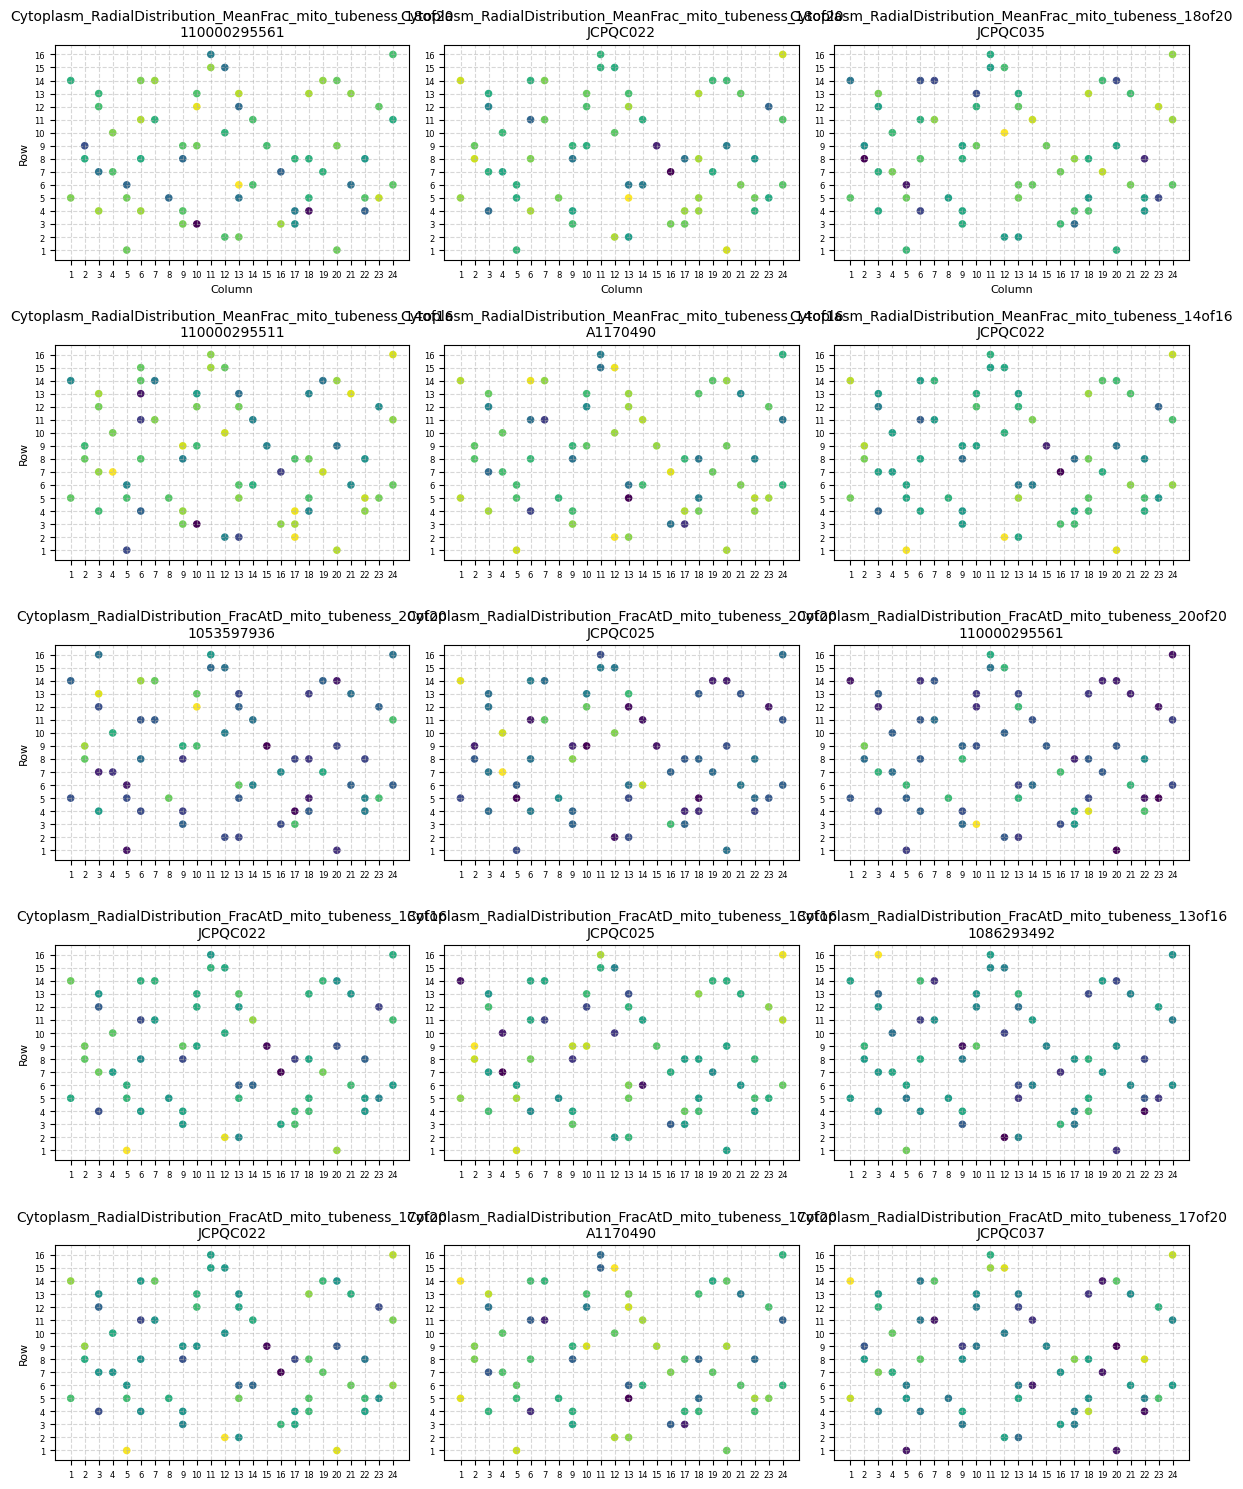

In [50]:

def plot_feature_plate_scatter(
    adata,
    top_n: int = 5,
    top_m: int = 3,
    plate_col: str = "Metadata_Plate",
    drug_id_col: str = "Metadata_JCP2022",
    drug_id_for_replicates: str = "DMSO",
    title_fontsize: int = 10,
    label_fontsize: int = 8,
    tick_fontsize: int = 6
) -> None:
    """
    Create a grid of scatter plots: each row is one of the top_n features (by variance of replicate SD),
    and each column is one of the top_m plates (by highest SD for that feature). 
    Points are the replicate wells plotted by (column, row), colored by the feature’s normalized value.
    Uses actual plate names in subplot titles, with reduced font sizes.
    """
    # Extract data and obs
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    obs = adata.obs
    var_names = list(adata.var_names)

    # Filter replicates and get plates
    rep = obs[drug_id_col] == drug_id_for_replicates
    plates = obs.loc[rep, plate_col].astype("category").cat.categories

    # Compute per-feature, per-plate SDs
    sd = pd.DataFrame(index=var_names, columns=plates, dtype=float)
    for p in plates:
        mask = (obs[plate_col] == p) & rep
        if mask.sum() < 2:
            continue
        med = np.median(X[mask], axis=0)
        devs = X[mask] - med
        sd[p] = np.std(devs, axis=0, ddof=1)

    # Select top_n features
    scores = sd.var(axis=1, skipna=True)
    top_feats = scores.nlargest(top_n).index.tolist()

    # For each feature, pick top_m plates
    feat2plates = {
        feat: sd.loc[feat].nlargest(top_m).index.tolist()
        for feat in top_feats
    }

    # Prepare grid
    fig, axes = plt.subplots(
        nrows=top_n, ncols=top_m,
        figsize=(4 * top_m, 3 * top_n),
        sharex=False, sharey=False
    )
    axes = np.atleast_2d(axes)

    # Determine full set of column and row ticks
    all_cols = sorted(obs.loc[rep, "Metadata_Column"].astype(int).unique())
    all_rows = sorted(obs.loc[rep, "Metadata_Row"].map(lambda x: ord(x.upper())-65+1).unique())

    # Plot each cell
    sc = None
    for i, feat in enumerate(top_feats):
        idx_feat = var_names.index(feat)
        # Normalize values across all replicates for color
        vals_all = X[rep, idx_feat]
        norm = Normalize(vmin=vals_all.min(), vmax=vals_all.max())

        for j, p in enumerate(feat2plates[feat]):
            ax = axes[i, j]
            mask = (obs[plate_col] == p) & rep
            cols = obs.loc[mask, "Metadata_Column"].astype(int)
            rows = obs.loc[mask, "Metadata_Row"].map(lambda x: ord(x.upper())-65+1)
            vals = X[mask, idx_feat]

            sc = ax.scatter(
                cols, rows,
                c=vals, cmap="viridis", # norm=norm,
                s=30, edgecolor="none"
            )
            ax.set_xticks(all_cols)
            ax.set_yticks(all_rows)
            ax.grid(True, linestyle="--", alpha=0.5)
            # set titles and labels with smaller fonts
            ax.set_title(f"{feat}\n{p}", fontsize=title_fontsize)
            if i == 0:
                ax.set_xlabel("Column", fontsize=label_fontsize)
            if j == 0:
                ax.set_ylabel("Row", fontsize=label_fontsize)
            ax.tick_params(axis='both', labelsize=tick_fontsize)

    # Shared colorbar
    # cbar = fig.colorbar(sc, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
    # cbar.set_label("Normalized value", fontsize=label_fontsize)
    # cbar.ax.tick_params(labelsize=tick_fontsize)

    plt.tight_layout()
    plt.show()

plot_feature_plate_scatter(adata, top_n=5, top_m=3)


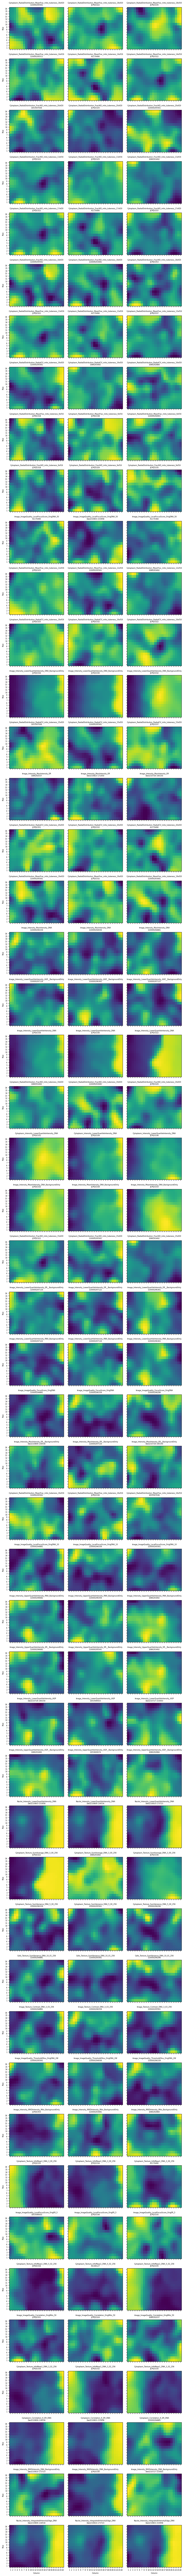

In [6]:
def plot_dmso_heatmaps(
    adata,
    top_n: int = 5,
    top_m: int = 3,
    plate_col: str = "Metadata_Plate",
    drug_id_col: str = "Metadata_JCP2022",
    drug_id_for_replicates: str = "DMSO",
    sigma: float = 1.5,
    title_fontsize: int = 6,
    tick_fontsize: int = 6
) -> None:
    """
    Improved heatmapping: places replicate values on the grid, then uses
    Gaussian-filtered weighted interpolation (value_sum / weight_sum)
    to avoid zero-padding artifacts.
    """
    # 1. Extract data & obs
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    obs = adata.obs
    feats = list(adata.var_names)

    # 2. Mask replicates and collect plates
    rep_mask = obs[drug_id_col] == drug_id_for_replicates
    plates = obs.loc[rep_mask, plate_col].astype("category").cat.categories

    # 3. Calculate per-feature, per-plate SDs for ranking
    sd = pd.DataFrame(index=feats, columns=plates, dtype=float)
    for p in plates:
        m = (obs[plate_col] == p) & rep_mask
        if m.sum() < 2:
            continue
        med = np.median(X[m], axis=0)
        devs = X[m] - med
        sd[p] = np.std(devs, axis=0, ddof=1)
    scores = sd.var(axis=1, skipna=True)
    top_feats = scores.nlargest(top_n).index.tolist()

    # 4. For each feature, pick top_m plates
    feat2plates = {
        f: sd.loc[f].nlargest(top_m).index.tolist()
        for f in top_feats
    }

    # 5. Determine grid dimensions
    all_cols = sorted(obs.loc[rep_mask, "Metadata_Column"].astype(int).unique())
    all_rows = sorted(obs.loc[rep_mask, "Metadata_Row"]
                      .map(lambda x: ord(x.upper())-65+1)
                      .unique())
    nrow, ncol = max(all_rows), max(all_cols)

    # 6. Setup subplots
    fig, axes = plt.subplots(
        nrows=top_n, ncols=top_m,
        figsize=(3*top_m, 2.5*top_n),
        sharex=True, sharey=True
    )
    axes = np.atleast_2d(axes)

    for i, feat in enumerate(top_feats):
        idx = feats.index(feat)
        # color normalization per feature
        vals_all = X[rep_mask, idx]
        norm = Normalize(vmin=vals_all.min(), vmax=vals_all.max())

        for j, p in enumerate(feat2plates[feat]):
            ax = axes[i, j]

            # Build grids
            val_grid = np.zeros((nrow, ncol), float)
            weight = np.zeros_like(val_grid)
            mask = (obs[plate_col] == p) & rep_mask
            cols = obs.loc[mask, "Metadata_Column"].astype(int).values - 1
            rows = obs.loc[mask, "Metadata_Row"].map(lambda x: ord(x.upper())-65).values
            vals = X[mask, idx]

            # Place values & weights
            val_grid[rows, cols] = vals
            weight[rows, cols] = 1.0

            # Gaussian smoothing
            smooth_vals = gaussian_filter(val_grid, sigma=sigma)
            smooth_wt   = gaussian_filter(weight, sigma=sigma)
            heatmap     = smooth_vals / np.maximum(smooth_wt, 1e-6)

            # Plot heatmap
            im = ax.imshow(
                heatmap,
                origin="lower",
                cmap="viridis",
                # norm=norm,
                aspect="auto",
                extent=(0.5, ncol+0.5, 0.5, nrow+0.5)
            )
            ax.set_xticks(all_cols)
            ax.set_yticks(all_rows)
            ax.tick_params(labelsize=tick_fontsize)
            ax.set_title(f"{feat}\n{p}", fontsize=title_fontsize)
            if i == top_n - 1:
                ax.set_xlabel("Column", fontsize=tick_fontsize)
            if j == 0:
                ax.set_ylabel("Row", fontsize=tick_fontsize)


    plt.tight_layout()
    plt.show()

plot_dmso_heatmaps(adata, top_n=50, top_m=3, sigma=1.5)


In [17]:
def normalize_plate_effect_dask(
    meta: pd.DataFrame,
    vals: np.ndarray,
    plate_col: str = "Metadata_Plate",
    drug_id_col: str = "Metadata_JCP2022",
    drug_id_for_replicates: str = "DMSO",
    spline_s: float = 1.0,
    exclude_extremes: int = 0
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Dask‐parallelized plate‐effect normalizer using 2D spline smoothing,
    but first dropping the n most extreme replicates per feature.

    Parameters
    ----------
    exclude_extremes : int
        Number of highest *and* lowest DMSO values to drop per feature before fitting.
    """
    meta_cp = meta.copy()
    corrected = np.empty_like(vals)

    # Precompute plate indices & replicate masks
    plates = meta_cp[plate_col].astype("category").cat.categories.tolist()
    plate_info = {
        plate: (
            np.where(meta_cp[plate_col] == plate)[0],
            (meta_cp.loc[meta_cp[plate_col] == plate, drug_id_col] == drug_id_for_replicates).values
        )
        for plate in plates
    }

    @dask.delayed
    def _process_plate(idx_plate, rep_mask):
        Vp = vals[idx_plate, :]  # (n_wells × n_feats)
        if rep_mask.sum() < max(3, 2*exclude_extremes+1):
            # not enough DMSO wells once extremes dropped
            return idx_plate, Vp

        # numeric coordinates for this plate
        sub_meta  = meta_cp.iloc[idx_plate]
        rows_all  = sub_meta["Metadata_Row"].map(lambda x: ord(x.upper())-65+1).astype(float).values
        cols_all  = sub_meta["Metadata_Column"].astype(int).astype(float).values

        # replicate coords (same for all features)
        rows_rep0 = rows_all[rep_mask]
        cols_rep0 = cols_all[rep_mask]

        corrected_plate = np.zeros_like(Vp)

        # loop features
        for j in range(Vp.shape[1]):
            y_rep0 = Vp[rep_mask, j]

            # optionally drop extremes
            if exclude_extremes > 0 and y_rep0.size > 2*exclude_extremes:
                # get sorted indices
                order = np.argsort(y_rep0)
                keep = order[exclude_extremes:-exclude_extremes]
                rows_rep = rows_rep0[keep]
                cols_rep = cols_rep0[keep]
                y_rep    = y_rep0[keep]
            else:
                rows_rep = rows_rep0
                cols_rep = cols_rep0
                y_rep    = y_rep0

            # median on trimmed replicates
            med = np.median(y_rep)

            # fit the spline
            s_adapt = max(spline_s, len(y_rep) * np.var(y_rep))
            spline = SmoothBivariateSpline(rows_rep, cols_rep, y_rep, s=s_adapt)

            bias   = spline(rows_all, cols_all, grid=False)

            # subtract & re-center
            corrected_plate[:, j] = Vp[:, j] - bias + med

        return idx_plate, corrected_plate

    # build & compute in parallel
    tasks = [_process_plate(idx, rep) for idx, rep in plate_info.values()]
    with ProgressBar():
        results = dask.compute(*tasks, scheduler="threads")

    # collect
    for idx_plate, corr_plate in results:
        corrected[idx_plate, :] = corr_plate

    return meta_cp, corrected

# 1) Extract from your AnnData:
meta = adata.obs
vals = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X

# 2) Run the Dask version (this will show a progress bar):
meta_corr, vals_corr = normalize_plate_effect_dask(
    meta, vals,
    plate_col="Metadata_Plate",
    drug_id_col="Metadata_JCP2022",
    drug_id_for_replicates="DMSO",
    spline_s=1.0,
    exclude_extremes=0
)

# 3) Replace in your AnnData for downstream plotting:
adata_corrected = adata.copy()
adata_corrected.X = vals_corr

[########################################] | 100% Completed | 15.40 s


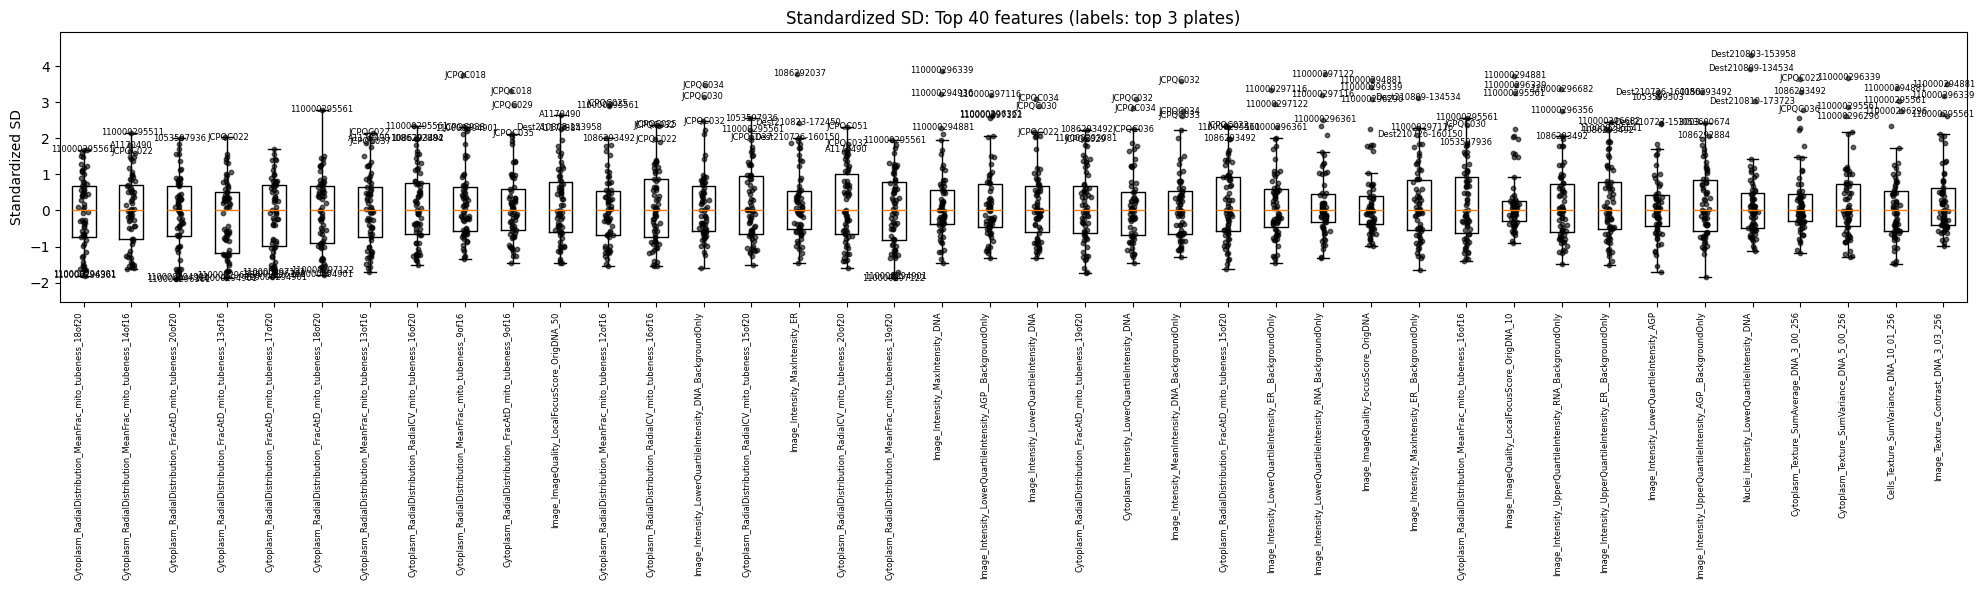

In [8]:
plot_sorted_sd_boxplots(adata, top_n=40, standardize=True)

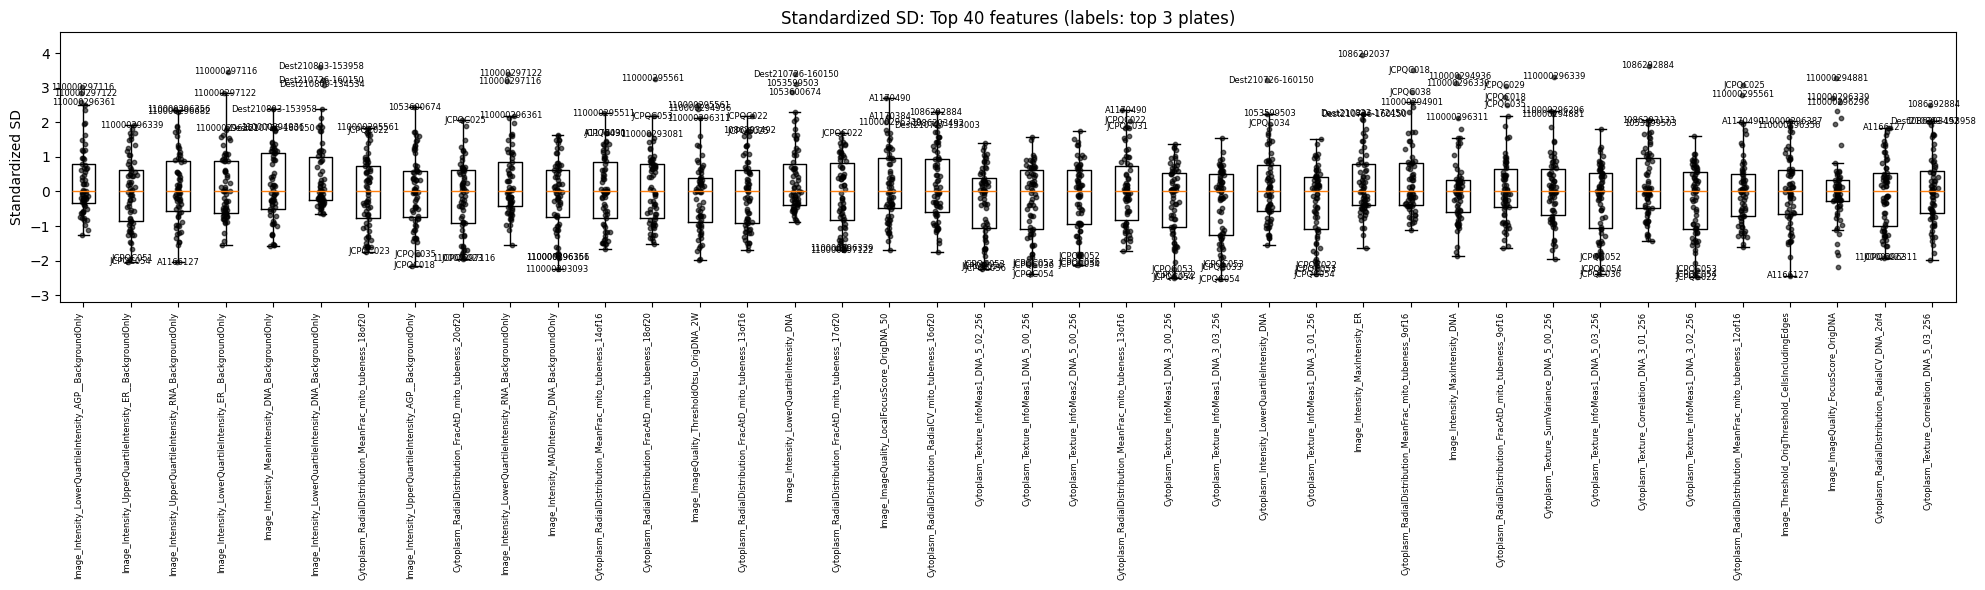

In [18]:
plot_sorted_sd_boxplots(adata_corrected, top_n=40, standardize=True)

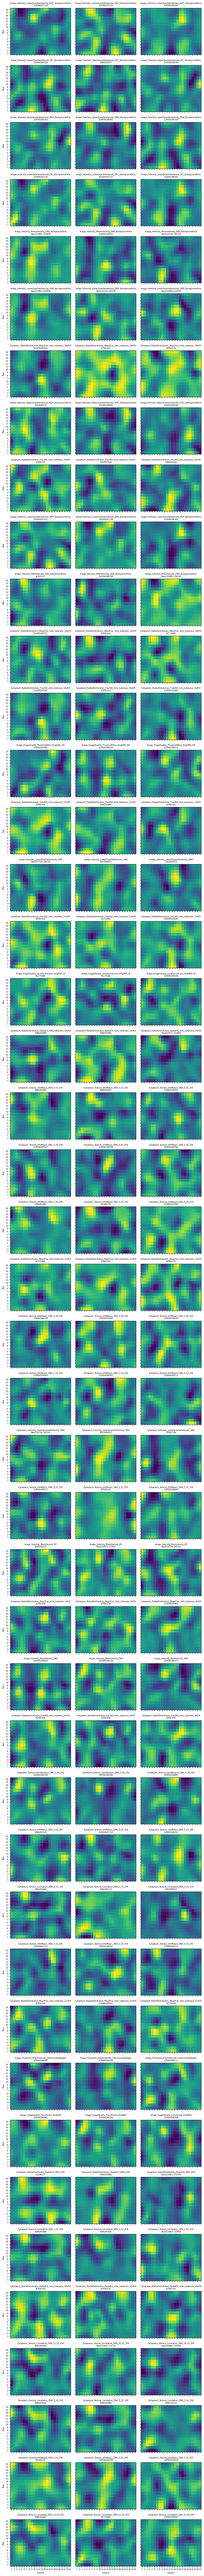

In [19]:
plot_dmso_heatmaps(adata_corrected, top_n=45, top_m=3, sigma=1.5)

## Quantify structure

In [30]:
def compute_plate_feature_moran(
    feature: str,
    plate: str,
    adata
) -> dict:
    """
    Compute Global Moran's I for one feature×plate by hand,
    using rook‐contiguity on the numeric Row/Col grid.
    """
    obs = adata.obs
    X   = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    fi  = adata.var_names.get_loc(feature)

    # mask for this plate
    mp = obs["Metadata_Plate"] == plate
    if mp.sum() < 3:
        return {"feature":feature, "plate":plate, "MoranI":np.nan}

    # numeric coords (0-based)
    rows = (obs.loc[mp, "Metadata_Row"]
            .astype(str)
            .map(lambda x: ord(x.upper())-65)
            .astype(int)
            .values)
    cols = obs.loc[mp, "Metadata_Column"].astype(int).values - 1
    vals = X[mp, fi]

    # infer grid size
    R = rows.max()+1
    C = cols.max()+1
    N = len(vals)

    # build full grid indices
    # we want to treat each well as a node in 0..R*C-1
    # but only keep those present
    present = set(rows*C + cols)
    yz = { (r*C + c): v for (r,c), v in zip(zip(rows,cols), vals) }
    zbar = np.mean(vals)

    # accumulate Moran's sums
    num = 0.0
    S0  = 0
    den = 0.0

    # denominator: sum (x_i - xbar)^2
    for v in vals:
        den += (v - zbar)**2

    # neighbor offsets for rook adjacency
    offsets = [-C, +C, -1, +1]

    # for each cell i
    for idx_flat, xi in yz.items():
        di = xi - zbar
        # for each neighbor
        for off in offsets:
            j = idx_flat + off
            # boundary checks: same row for left/right
            if off in [-1, +1]:
                # must stay in same row
                if (idx_flat // C) != (j // C):
                    continue
            if j in yz:
                num += di * (yz[j] - zbar)
                S0  += 1

    I = np.nan if den == 0 or S0 == 0 else (N / S0) * (num / den)
    return {"feature":feature, "plate":plate, "MoranI":I}

features = list(adata.var_names)
plates   = adata.obs["Metadata_Plate"].astype(str).unique().tolist()

tasks = [dask.delayed(compute_plate_feature_moran)(feat, plate, adata)
         for feat in features
         for plate in plates]

with ProgressBar():
    results = dask.compute(*tasks, scheduler="threads")

df_mi_before = pd.DataFrame(results)
df_mi_before

[########################################] | 100% Completed | 232.58 s


feature       plate    MoranI
0                   Cells_AreaShape_Compactness  1053597936  0.032390
1                   Cells_AreaShape_Compactness  1053599503  0.030483
2                   Cells_AreaShape_Compactness  1053600674  0.012589
3                   Cells_AreaShape_Compactness  1086289686  0.059317
4                   Cells_AreaShape_Compactness  1086292037  0.047850
...                                         ...         ...       ...
67183  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC038  0.038539
67184  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC051  0.312727
67185  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC052  0.112204
67186  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC053  0.161588
67187  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC054  0.108882

[67188 rows x 3 columns]

In [51]:
features = list(adata_corrected.var_names)
plates   = adata_corrected.obs["Metadata_Plate"].astype(str).unique().tolist()

tasks = [dask.delayed(compute_plate_feature_moran)(feat, plate, adata_corrected)
         for feat in features
         for plate in plates]

with ProgressBar():
    results_corrected = dask.compute(*tasks, scheduler="threads")

df_mi_corrected = pd.DataFrame(results_corrected)
df_mi_corrected

[########################################] | 100% Completed | 240.96 s


feature       plate    MoranI
0                   Cells_AreaShape_Compactness  1053597936  0.054994
1                   Cells_AreaShape_Compactness  1053599503  0.269299
2                   Cells_AreaShape_Compactness  1053600674  0.086498
3                   Cells_AreaShape_Compactness  1086289686  0.120464
4                   Cells_AreaShape_Compactness  1086292037  0.215768
...                                         ...         ...       ...
67183  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC038  0.245905
67184  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC051  0.164547
67185  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC052  0.177893
67186  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC053  0.144283
67187  Nuclei_Texture_SumVariance_RNA_10_01_256    JCPQC054  0.091527

[67188 rows x 3 columns]

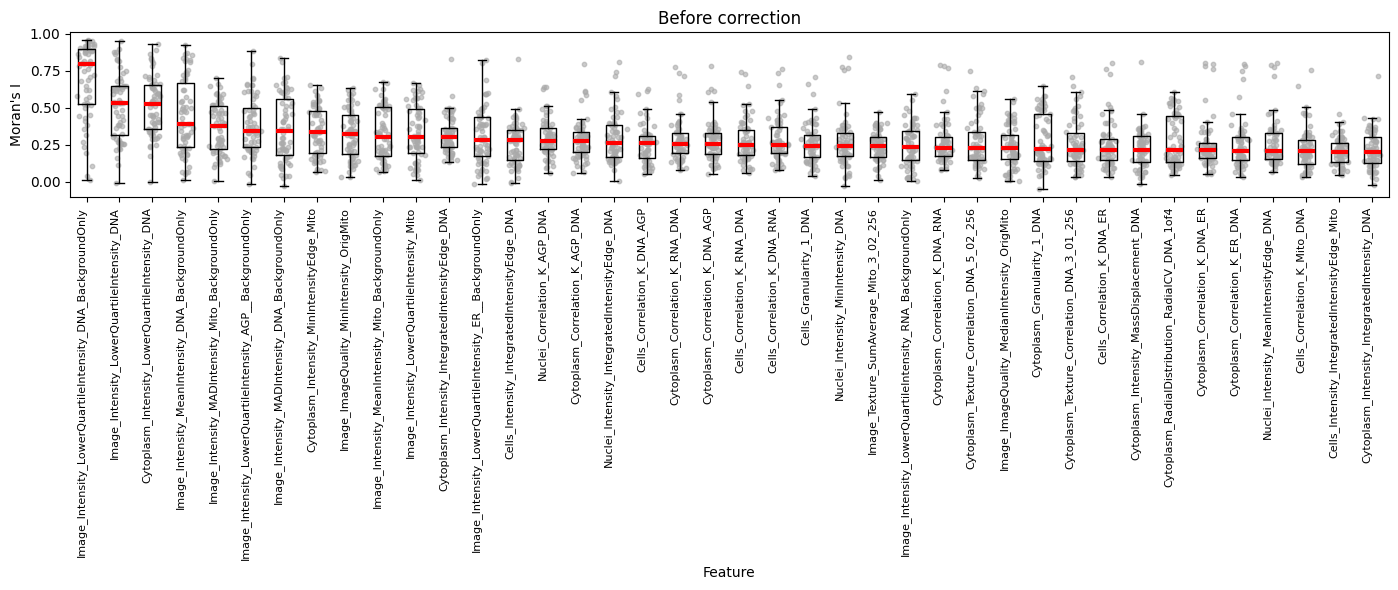

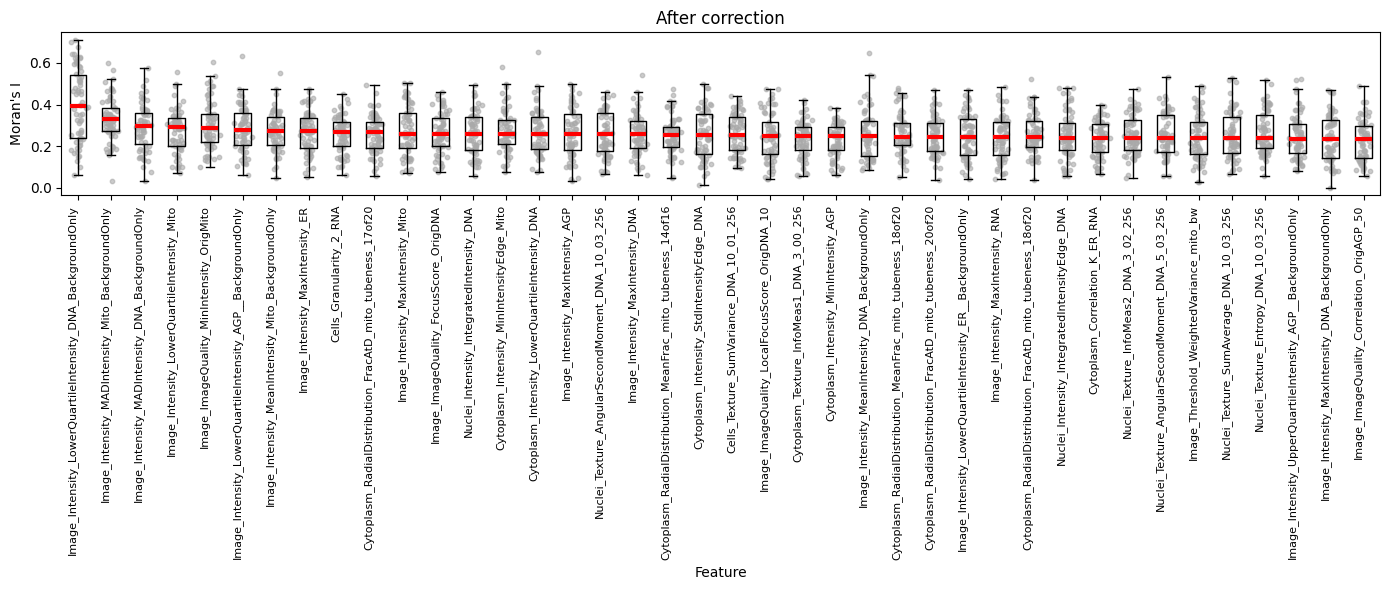

In [53]:
def plot_morans_boxplot(
    df_mi: pd.DataFrame,
    top_n: int = None,
    title: str | None = None,
    figsize: tuple = (12, 6),
    jitter: float = 0.1
) -> None:
    """
    Boxplot of Moran's I per feature, with one box per feature summarizing plates,
    overlaid with jittered scatter points. Title can include a tag like 'before norm' or 'after norm'.
    
    Parameters
    ----------
    df_mi : pd.DataFrame
        Must contain columns ['feature','plate','MoranI'].
    top_n : int or None
        If provided, only plot the top_n features by mean Moran's I.
    title_tag : str
        Optional tag to append to title, e.g. 'before norm' or 'after norm'.
    figsize : tuple
        Figure size.
    jitter : float
        Standard deviation of horizontal jitter for scatter points.
    """
    # compute mean Moran's I per feature
    means = df_mi.groupby('feature')['MoranI'].median()
    order = means.sort_values(ascending=False).index.tolist()
    order = order[:top_n] if top_n else order
    
    # prepare data for boxplot
    data_list = [df_mi.loc[df_mi['feature'] == feat, 'MoranI'].dropna().values for feat in order]
    positions = np.arange(len(order)) + 1
    
    # plot boxplot
    fig, ax = plt.subplots(figsize=figsize)
    median_props = dict(color="red", linewidth=3)

    bp = ax.boxplot(
        data_list,
        positions=positions,
        showfliers=False,
        medianprops=median_props
    )    
    # overlay scatter points underneath
    for i, feat in enumerate(order):
        yvals = df_mi.loc[df_mi['feature'] == feat, 'MoranI'].dropna().values
        xvals = np.random.normal(loc=positions[i], scale=jitter, size=len(yvals))
        ax.scatter(xvals, yvals, s=10, color='darkgrey', alpha=0.6, zorder=1)
    
    # formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(order, rotation=90, ha='right', fontsize=8)
    ax.set_xlabel('Feature', fontsize=10)
    ax.set_ylabel("Moran's I", fontsize=10)
    if title:
        ax.set_title(title, fontsize=12)
    else:
        ax.set_title("Distribution of Moran's I per Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_morans_boxplot(df_mi_before, top_n=40, figsize=(14, 6), title="Before correction")
plot_morans_boxplot(df_mi_corrected, top_n=40, figsize=(14, 6), title="After correction")


## Plot the pre-integration embeddings

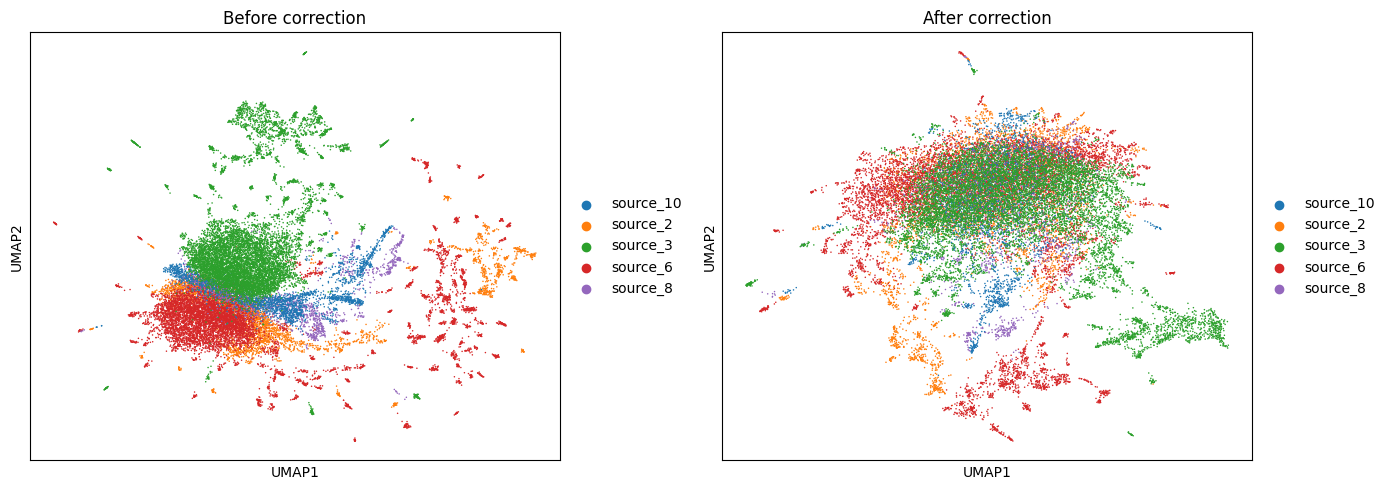

In [16]:
sc.pp.pca(adata, n_comps=100)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pp.pca(adata_corrected, n_comps=100)
sc.pp.neighbors(adata_corrected)
sc.tl.umap(adata_corrected)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sc.pl.umap(adata, color="Metadata_Source", ax=axs[0], show=False, title="Before plate-effect correction")
sc.pl.umap(adata_corrected, color="Metadata_Source", ax=axs[1], show=False, title="After plate-effect correction")

plt.tight_layout()